In [1]:
import json
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import seaborn as sb
import re
from scipy.stats import ranksums
from statsmodels.stats.multitest import multipletests
from matplotlib.colors import LogNorm, Normalize
import warnings

warnings.filterwarnings("ignore", 'This pattern has match groups')
pd.set_option('display.max_columns', None)

**Data import**

In [2]:
combined = []
combined_user = []
for json_file in glob.glob("Raw data/*.json"): #Assuming that your json files and .py file in the same directory
    with open(json_file, "rb") as infile:
        temp = json.load(infile)
        combined.append(temp['data'])
        combined_user.append(temp['includes']['users'])

content = []
content = [item for sublist in combined for item in sublist]
users = [item for sublist in combined_user for item in sublist]

df = pd.json_normalize(content)

**Data cleaning**

In [3]:
print(len(df.index))
df['date'] = df['created_at'].str[:10]
df = df.drop(columns=['created_at','geo.coordinates.type', 'geo.place_id', 'withheld.copyright', 'withheld.country_codes'])
geo = df.dropna(subset=['geo.coordinates.coordinates'])
df['engagement'] = df['public_metrics.retweet_count'] + df['public_metrics.reply_count'] + df['public_metrics.like_count']
df = df.sort_values(by=['engagement'], ascending=False)
df['text'] = df['text'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True).replace(r'@\S+', '', regex=True)
df = df.drop_duplicates(subset=['text'])
print(len(df.index))
df = df[~df['text'].str.lower().str.contains(r'sgmo|bmrn|krtx|sny|regn|seovf|$qure|gugg|pfe|rgnx|seovf|nvs|srpt|\$once|sgtx|beam|cbio|ntla')]
print(len(df.index))
df = df[~df['text'].str.lower().str.contains(r'bts|taehyung|midni|netflix|hollywood| actor| rape|actress|time of memory|vampire|sexual|horny|incest|white race|nigga|emotional hemophilia|terrorist|feminist|marry|married|benghazi|aristocrat|queen|victoria|prince|rasputin|czar|tsar|bloodline| inbre|habsburg|royal|stab|covid death|bullet|auto accident|shoot|car wreck|car crash|cause of death|chauvin|bear|knife|candaceo|boebert| shot')]
print(len(df.index))

57027
50868
49512
45590


**Thematic Analysis**

In [ ]:
df['gene therapy'] = 0
df.loc[df['text'].str.lower().str.contains('gene(| )therapy|gene(| )editing|biomarin|spark(| )therapeutics|valrox|uniqure|aav'),'gene therapy'] = 1
df['contamination'] = 0
df.loc[df['text'].str.lower().str.contains('blood(| )inquiry|contaminated(| )blood|blood(| )scandal|hiv|ryan(| )white|aids|infected(| )blood'),'contamination'] = 1
df['whd'] = 0
df.loc[df['text'].str.lower().str.contains('whd|world(| )h(ae|e)mophilia(| )day|awareness'),'whd'] = 1
df['research'] = 0
df.loc[df['text'].str.lower().str.contains('wfh(20|18|19|21)|isth(20|21)|ash(19|20|21)|mice|mouse|preprint|open(| )access|research|abstract|publication|nih|phd (work|position|paper)|in the literature|postdoc|phase 1 study|phase 2 study|phase 3 study|trial|preclinical|pre-clinical|manuscript'),'research'] = 1
df['management'] = 0
df.loc[df['text'].str.lower().str.contains('treatment(| )challenge|protein therap|mophilia treatment|personalized(| )(care| care)|treatment plan|biv001|physiotherapy|mophilia care|mophilia management|management of|prophyla|standard of care|patient care|guideline|evidence-based|evidence based|desmopressin|octocog|replacement therapy|recombinant|hemlibra|hemelibra|benefix|novoseven|advate|eloctate|humate|kogenate|recombinate|koate|monoclate|hemofil|mononine|alphanine|xyntha|profilnine|bebulin|alprolix|obizur|ixinity|novoeight|rebinyn|afstyla|esperoct'),'management'] = 1
df['covid'] = 0
df.loc[df['text'].str.lower().str.contains('covid|corona|pandemic|case(| )rates|lockdown|quar(a|e)ntine|mask|vaccin|vax|jab'),'covid'] = 1
df['symptoms'] = 0
df.loc[df['text'].str.lower().str.contains('chronic(| )pain|bruis|joint|swell|hematoma|stool'),'symptoms'] = 1
df.loc[(df['text'].str.lower().str.contains('bleed|bled|bloody') & df['text'].str.lower().str.contains('sudden|nose|breakthrough|internal|prolong|wound')),'symptoms'] = 1
df['treatment cost'] = 0
df.loc[df['text'].str.lower().str.contains('insurance|medicare|medicaid|(\W|^)(aca)(\W|$)|medical bill|dental bill|expensive|pay for|costs|cost of|funds for|gofundme|dollars|affordable|affordability|costly|bankrup'),'treatment cost'] = 1
df['inhibitors'] = 0
df.loc[df['text'].str.lower().str.contains('bethesda|inhibitor|autoantibody|autoantibodies|anti-fviii|anti-fix'),'inhibitors'] = 1
df['athletics'] = 0
df.loc[df['text'].str.lower().str.contains('runners|dowsett|bombardier|gym|sport|physicalactivity|physically active|physical activity|athlet|marathon|grand tour|bik|exercis'),'athletics'] = 1
df['mental health'] = 0
df.loc[df['text'].str.lower().str.contains('distress|emotional|mental(| )illness|mentalhealth|anxiety|depress|suicid|mental(| )health'),'mental health'] = 1

cat = df.iloc[:, -11:].astype(int)
coocc = cat.T.dot(cat)
corr = cat.corr()
cat_na = df.iloc[:, -11:].astype(int).replace({'0':np.nan, 0:np.nan})
all_na = cat_na.isnull().all(1)
all_na = df[all_na]
cat_na = cat_na.dropna(how='all')
print(len(cat_na.index))
print(20316/45590)

fig, ax = plt.subplots(figsize=(12,7), dpi=300) 
sb.heatmap(coocc, annot=True, cmap='Blues', norm=LogNorm(), fmt='g')

**Sentiment analysis**

In [9]:
sentences = df['text'].to_list()
sent = []

analyzer = SentimentIntensityAnalyzer()
for sentence in sentences:
    vs = analyzer.polarity_scores(sentence)
    sent.append(vs)
    
copy_sent = pd.json_normalize(sent)
copy = df.reset_index().drop(columns=['public_metrics.retweet_count','public_metrics.reply_count','public_metrics.like_count','public_metrics.quote_count','geo.coordinates.coordinates'])
sent_df = pd.concat([copy, copy_sent],axis=1).sort_values(by=['compound'], ascending=False)

In [ ]:
sc = sent_df['compound'].to_frame()
sc.rename(columns={ sc.columns[0]: "all tweets" }, inplace = True)
sc['athletics'] = sent_df.loc[sent_df['athletics'] == 1]['compound']
sc['whd'] = sent_df.loc[sent_df['whd'] == 1]['compound']
sc['management'] = sent_df.loc[sent_df['management'] == 1]['compound']
sc['research'] = sent_df.loc[sent_df['research'] == 1]['compound']
sc['covid'] = sent_df.loc[sent_df['covid'] == 1]['compound']
sc['gene therapy'] = sent_df.loc[sent_df['gene therapy'] == 1]['compound']
sc['treatment cost'] = sent_df.loc[sent_df['treatment cost'] == 1]['compound']
sc['inhibitors'] = sent_df.loc[sent_df['inhibitors'] == 1]['compound']
sc['mental health'] = sent_df.loc[sent_df['mental health'] == 1]['compound']
sc['symptoms'] = sent_df.loc[sent_df['symptoms'] == 1]['compound']
sc['contamination'] = sent_df.loc[sent_df['contamination'] == 1]['compound']
sb.set(rc={"figure.dpi":300, 'savefig.dpi':300})
sb.violinplot(data=sc)
plt.ylabel('Compound sentiment')
temp = plt.xticks(rotation = 75)
plt.plot(dpi=300)

In [12]:
sc_list = sc.columns.values.tolist()[1:]
rs_results = []
rs_stat = []
for i in sc_list:
    rs_stat.append(ranksums(sc[sc[i].isna()]['all tweets'].dropna(), sc[i].dropna())[0])
    rs_results.append(ranksums(sc[sc[i].isna()]['all tweets'].dropna(), sc[i].dropna())[1])
res = multipletests(rs_results)
temp = pd.DataFrame({'Category': sc_list, 'Test statistic': rs_stat, 'p value': res[1], 'Significant at α = 0.05': res[0]})
temp.to_csv('Rank_sum_categories.csv')

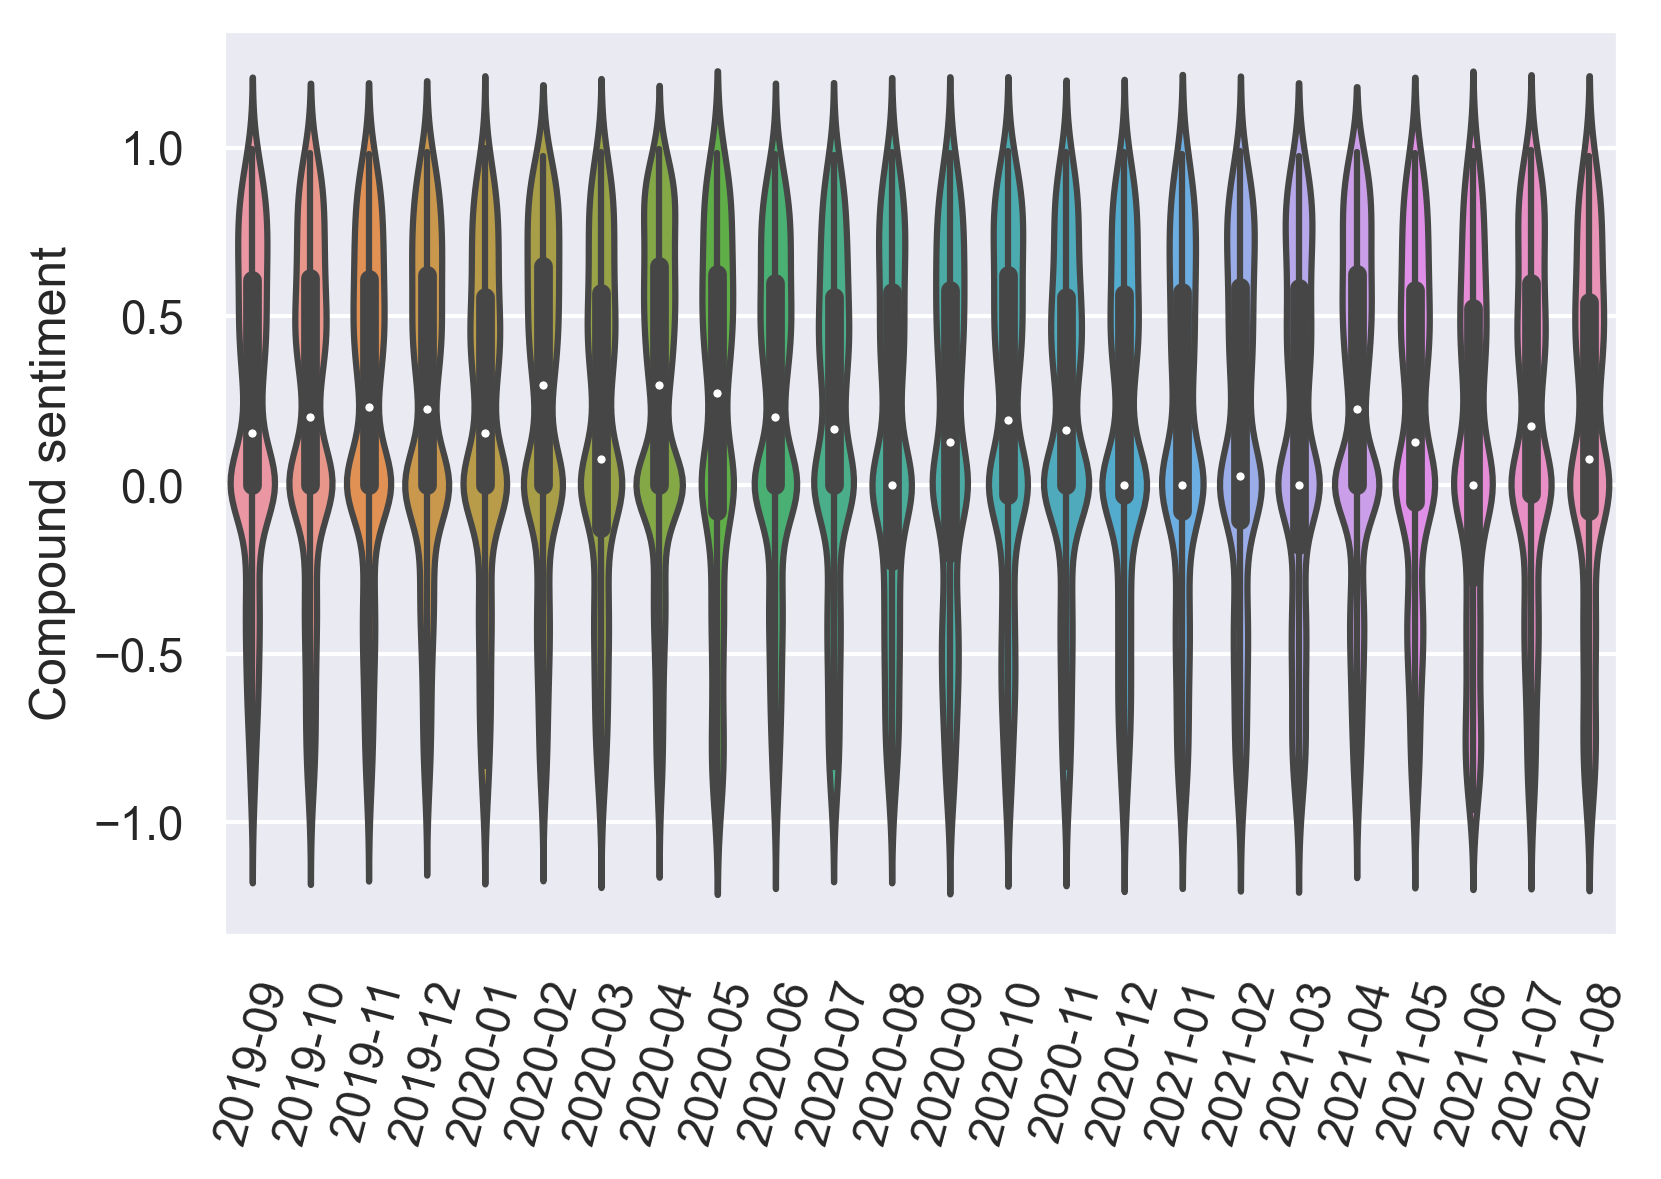

In [28]:
sent_df['ym'] = sent_df['date'].str[:7]
pos = sent_df.loc[sent_df['compound'] >= 0.05]
neg = sent_df.loc[sent_df['compound'] <= -0.05]
neut = sent_df.loc[np.abs(sent_df['compound']) < 0.05]

pos = pos.groupby(['ym']).count()['index']#.tolist()
neg = neg.groupby(['ym']).count()['index']#.tolist()
neut = neut.groupby(['ym']).count()['index']#.tolist()
total = pos+neg+neut
pos = pos/total
neg = neg/total
neut = neut/total
sent = pd.DataFrame({'pos': pos, 'neut': neut, 'neg': neg})

sm = sent_df.groupby(['ym'])['compound'].apply(pd.DataFrame)
sb.set(rc={"figure.dpi":300, 'savefig.dpi':300})
sb.violinplot(data=sm)
plt.ylabel('Compound sentiment')
temp = plt.xticks(rotation = 75)

**User analysis**

In [15]:
us = df.sort_values(by=['author_id'])
counts = us.groupby(['author_id']).size().to_list()
us = us.drop_duplicates(subset=['author_id'])
us['counts'] = counts
us = us[['author_id','counts']].sort_values(by=['counts'], ascending=False)
us = us.set_index('author_id')
ds = pd.json_normalize(users)
ds = ds.drop_duplicates(subset=['id'])
ds = ds.set_index('id')
us = us.join(ds).sort_values(by=['counts'], ascending=False)
us['category'] = 'unidentified'
us.loc[us['description'].str.lower().str.contains('treatment center|blood disorders center|hemophilia center|haemophilia centre|hospital'),'category'] = 'hospitals and treatment centers'
us.loc[us['username'].str.lower().str.contains('htc|hospital'),'category'] = 'hospitals and treatment centers'
us.loc[us['description'].str.lower().str.contains('blog|podcast|knowledge base'),'category'] = 'non-journal media'
us.loc[us['description'].str.lower().str.contains('nurse|anp|advanced practice'),'category'] = 'non-physician provider'
us.loc[us['description'].str.lower().str.contains('professor|research|scientist|phd candidate|postdoc'),'category'] = 'research and academia'
us.loc[us['description'].str.lower().str.contains('mophilia society|advocacy|charity|advocacy|nonprofit|foundation|strives to|committed to|advocate'),'category'] = 'support and advocacy'
us.loc[us['username'].str.lower().str.contains('nhf'),'category'] = 'support and advocacy'
us.loc[us['description'].str.lower().str.contains('hematologist|haematologist|physician|md|doctor|heme/onc|pediatrician|surgeon|nhs dr|anesthesiologist|intensivist'),'category'] = 'physician'
us.loc[us['description'].str.lower().str.contains('hemophiliac|haemophiliac|bleeder|i have hemophilia'),'category'] = 'patient'
us.loc[us['description'].str.lower().str.contains('pharmacy'),'category'] = 'pharmacy'
us.loc[us['description'].str.lower().str.contains('journal'),'category'] = 'journal'
us.loc[us['description'].str.lower().str.contains('pharmaceutical'),'category'] = 'pharmaceutical organization'
us.to_csv('Users.csv')

In [16]:
labeled = pd.read_excel('Labeled.xlsx')
top200 = us.drop(columns=['withheld.country_codes','category'])
top200['author_id'] = top200.index
iu = top200.merge(labeled, how='left').iloc[:250,:]
print(pd.value_counts(iu['category']))
sum(pd.value_counts(iu['category']))

support and advocacy               80
unidentified                       36
non-journal media                  29
pwbd                               27
physician                          18
pharmaceutical organization        16
continuing education                9
journal                             8
non-physician provider              8
pharmacy                            6
professional organization           6
research and academia               5
hospitals and treatment centers     2
Name: category, dtype: int64


250

In [17]:
iu['author_id'] = iu['author_id'].astype('int64')
iu['a_temp'] = iu['author_id']
include = iu['author_id'].tolist()
sent_df['author_id'] = sent_df['author_id'].astype('int64')
uavg = sent_df[sent_df['author_id'].isin(include)].groupby(['author_id']).sum()
uavg['a_temp'] = uavg.index
uavg = uavg.merge(iu, how='left')
uavg = uavg.drop(columns = ['index','description','name','a_temp'])
pd.reset_option('all')
up = uavg.iloc[: , :12].div(uavg['counts'], axis=0)
up['compound'] = uavg['compound']/uavg['counts']
up['category'] = uavg['category']
up = up.groupby(['category'])

[Text(0.5, 162.75, 'post category'),
 Text(349.74999999999994, 0.5, 'user category')]

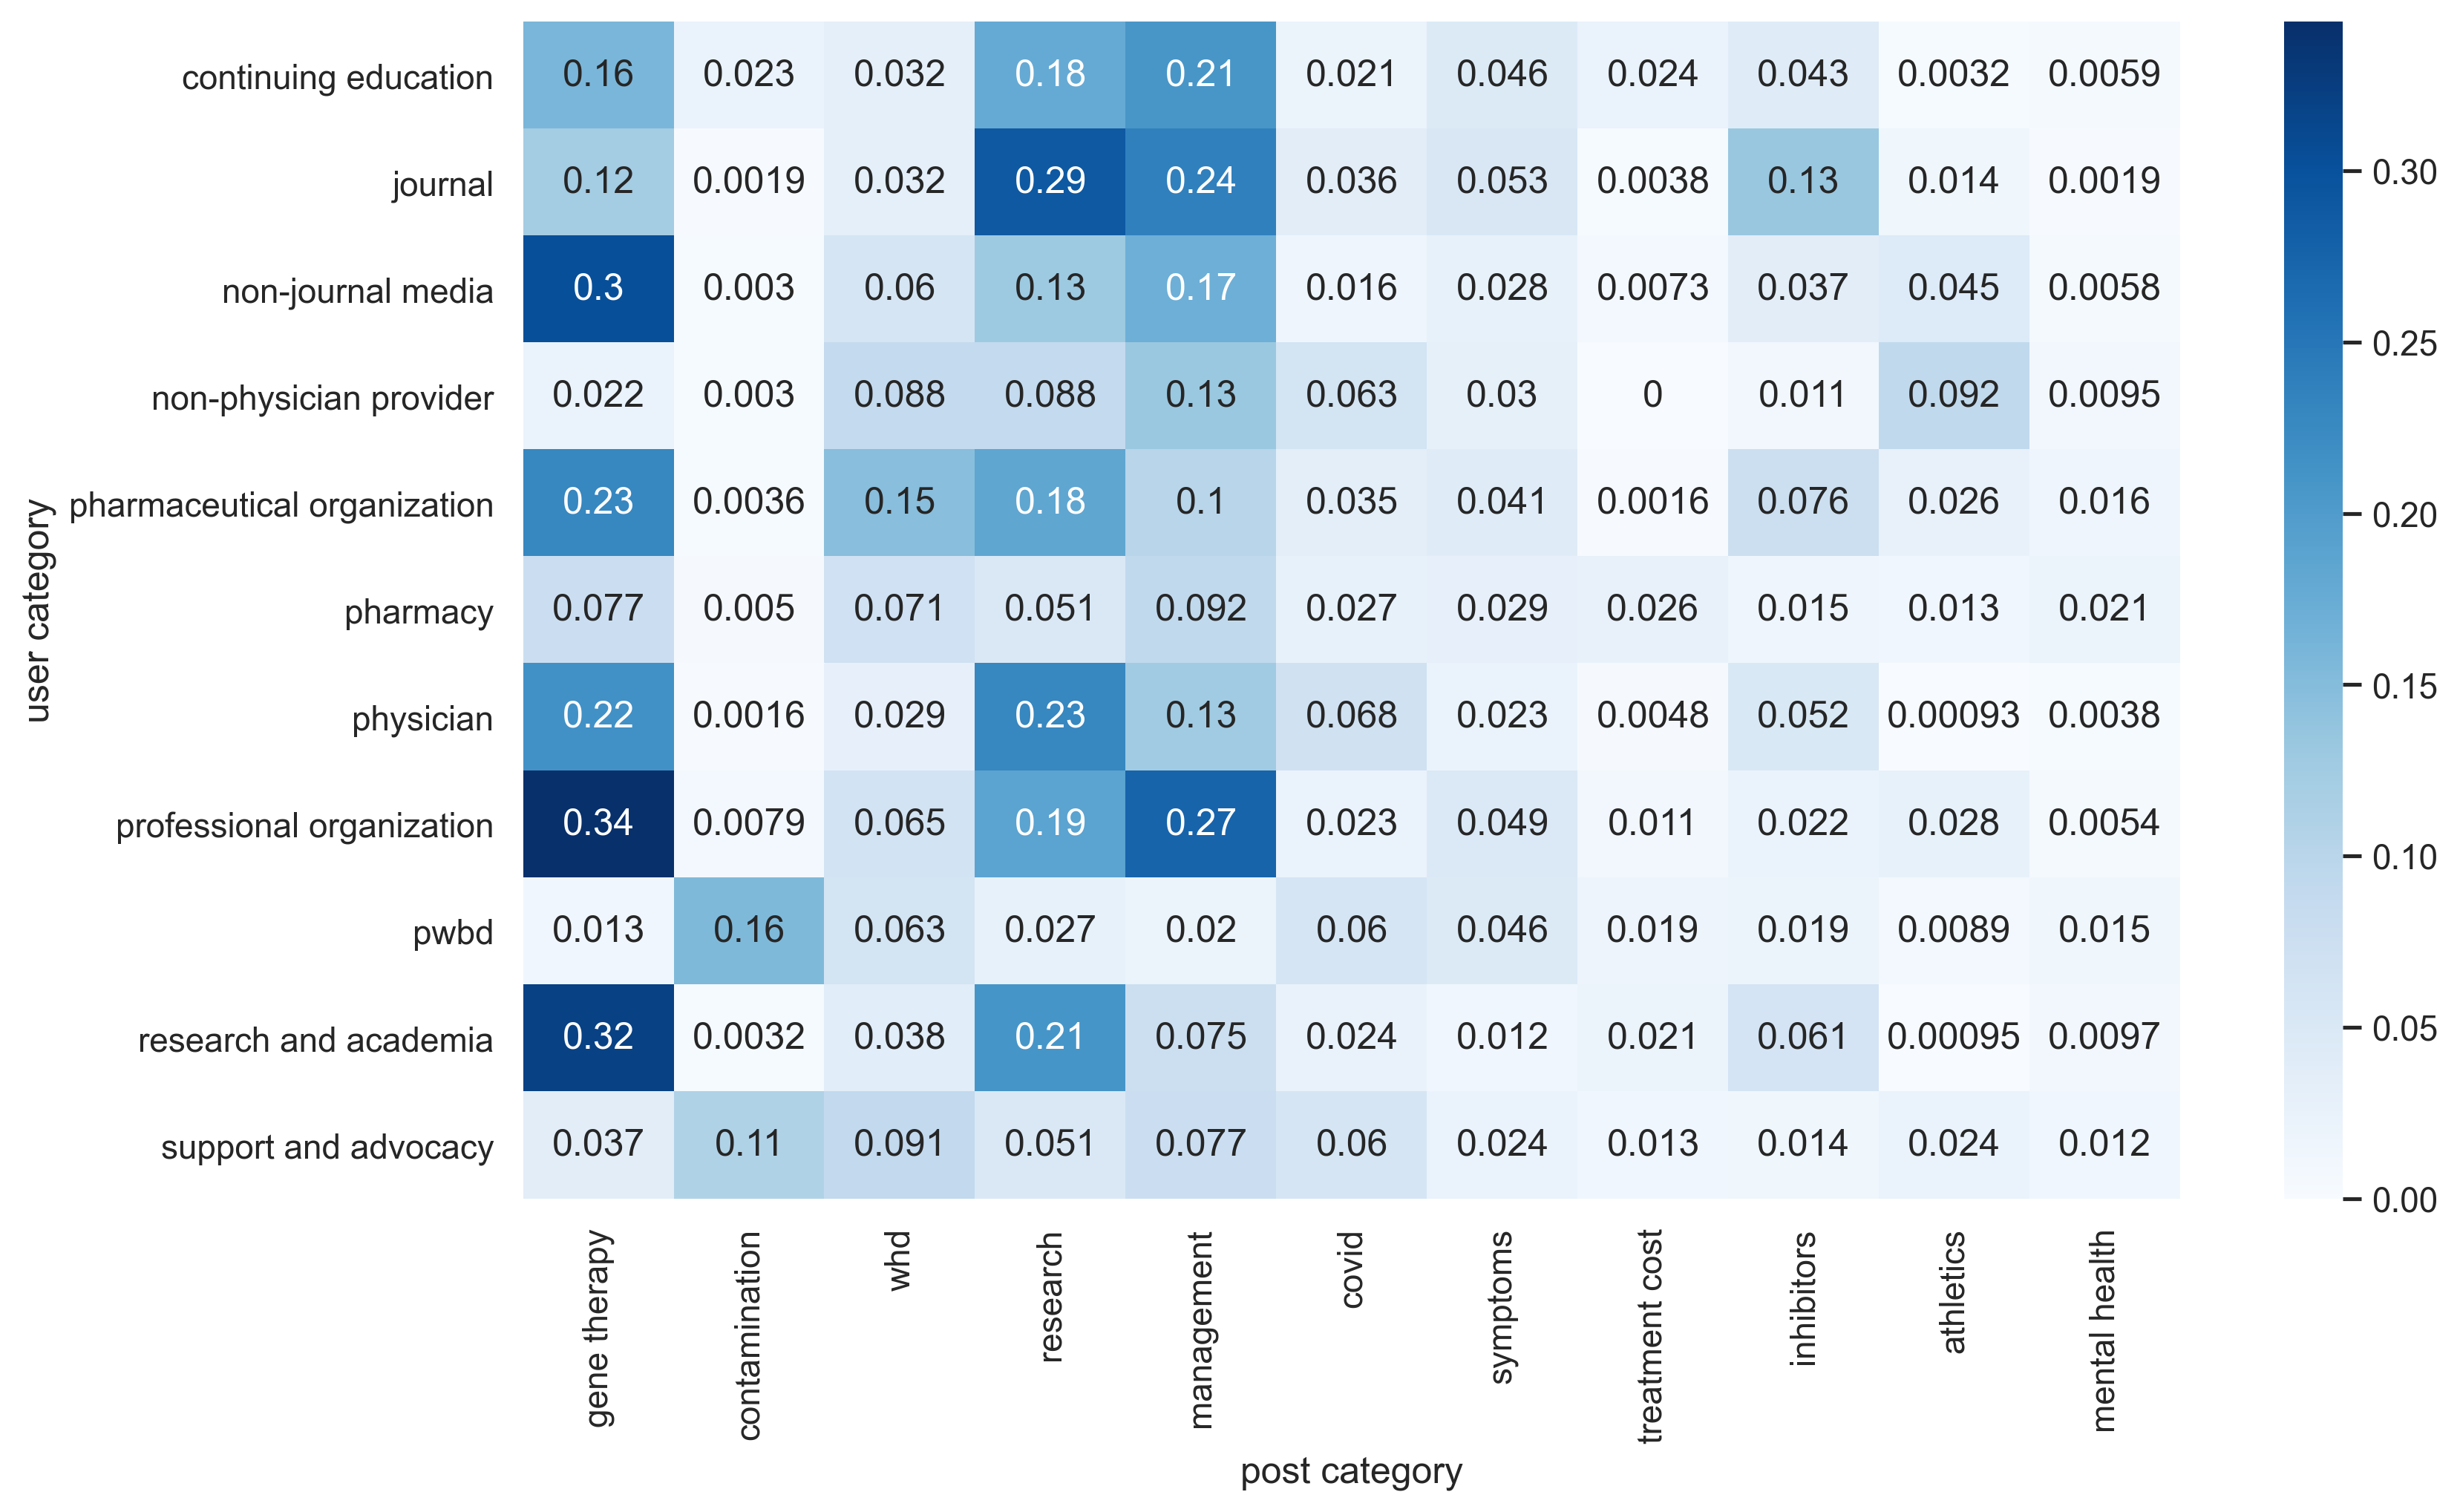

In [20]:
up = uavg.iloc[: , :12].div(uavg['counts'], axis=0)
up['compound'] = uavg['compound']/uavg['counts']
up['category'] = uavg['category']
up = up.groupby(['category'])
pdist = up.mean().iloc[:12, 1:12].drop(['hospitals and treatment centers'])
#pd.options.display.float_format = '{:, .2f}'.format
#pdist.style.background_gradient(cmap='Blues', vmin=0, vmax=1)

fig, ax = plt.subplots(figsize=(12,7), dpi=300) 
sb.heatmap(pdist, annot=True, cmap='Blues')
ax.set(xlabel='post category', ylabel='user category')

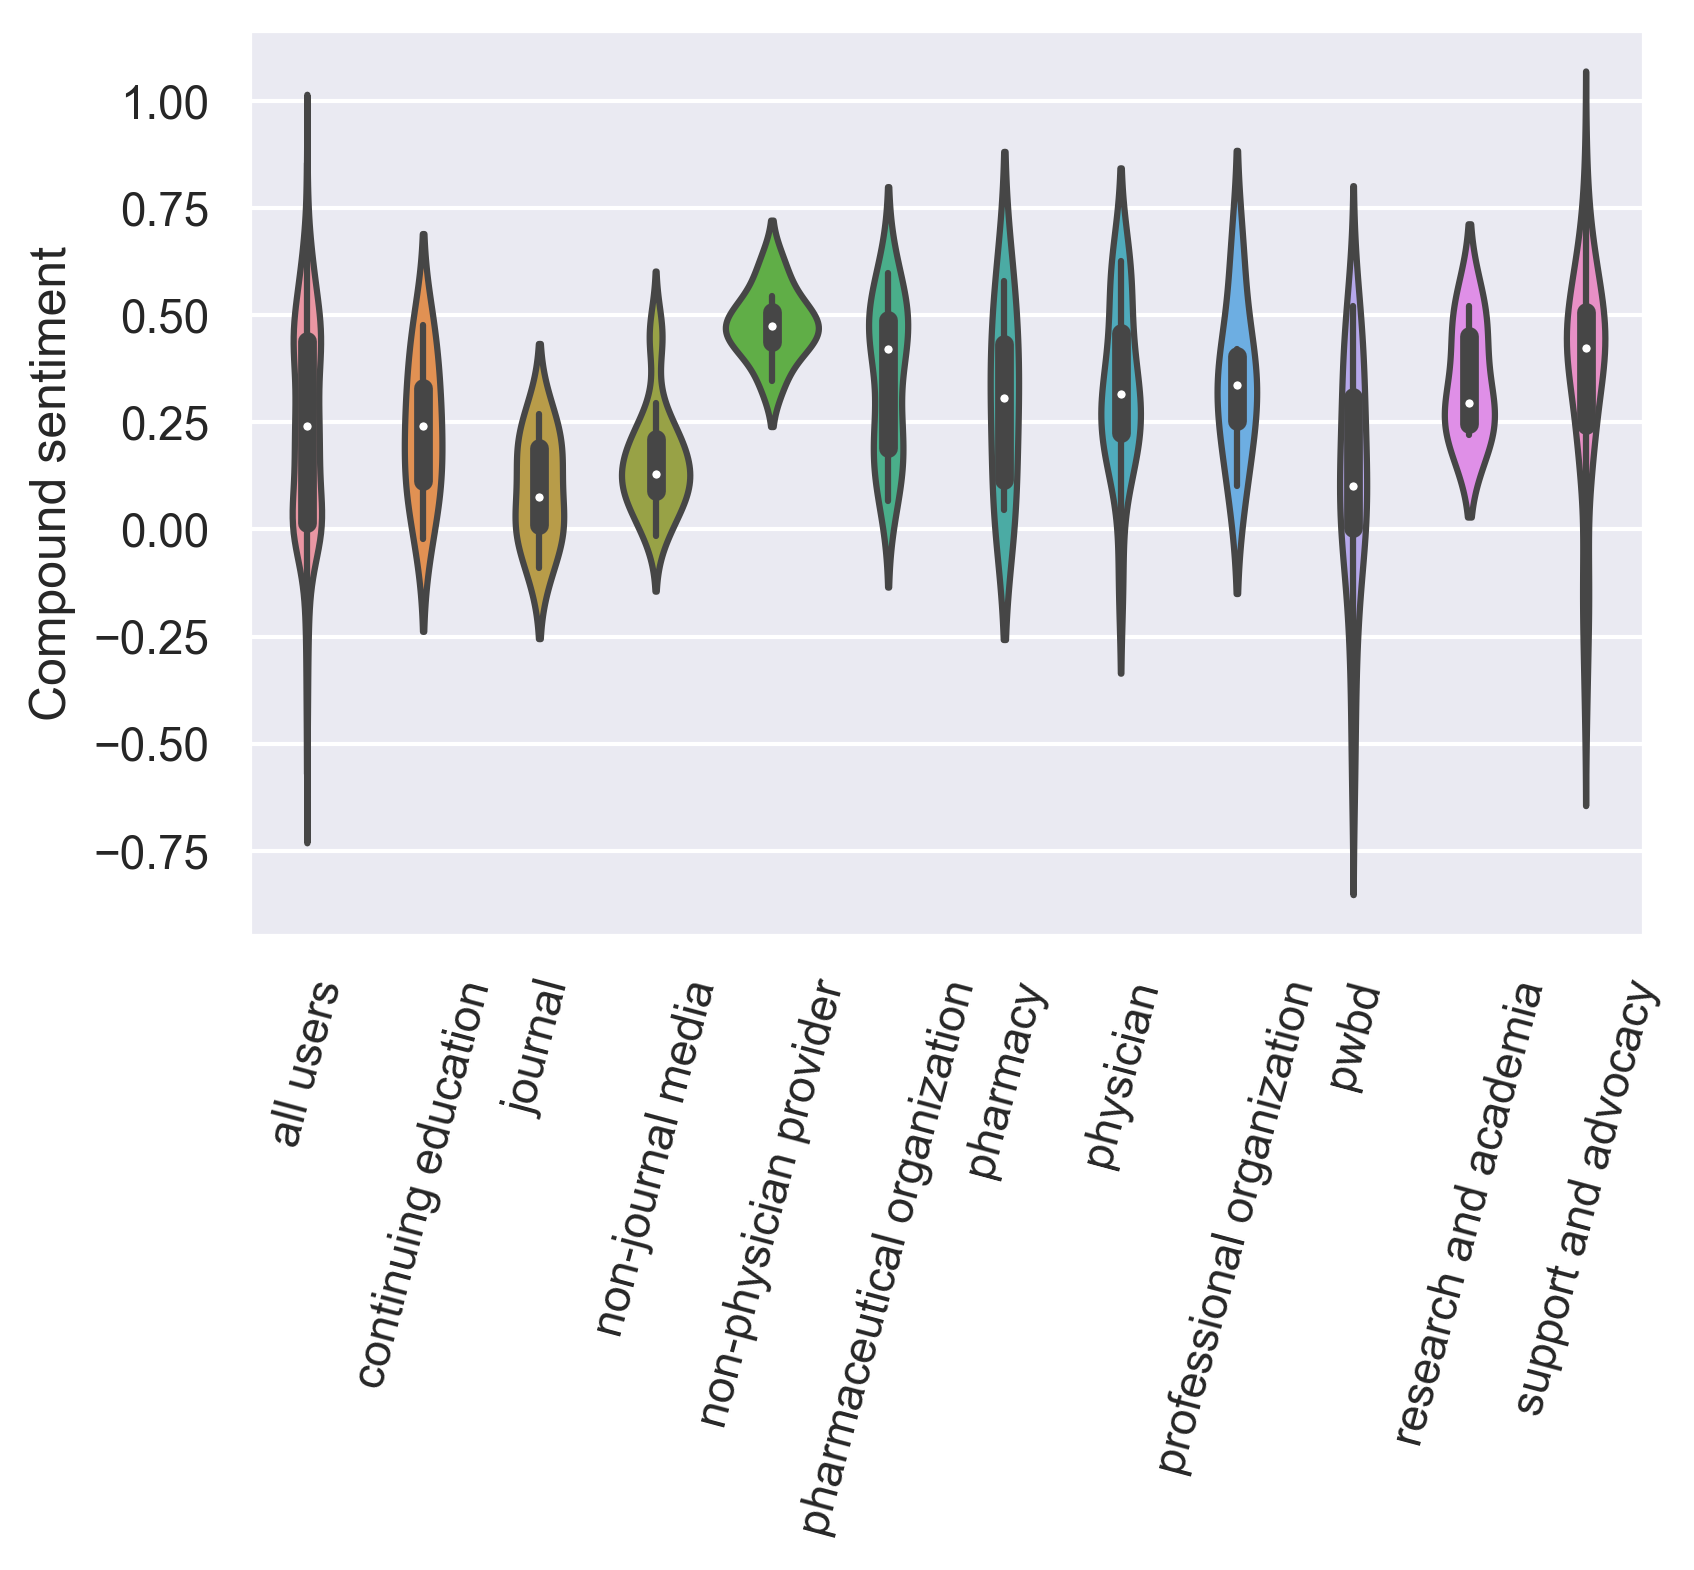

In [22]:
usm = up['compound'].apply(pd.DataFrame).drop(columns=['hospitals and treatment centers','unidentified'])
usm['all users']=usm.sum(axis=1)
usm = usm.reindex(sorted(usm.columns), axis=1)
sb.set(rc={"figure.dpi":300, 'savefig.dpi':300})

#sm.boxplot(rot=60, showfliers=False, showmeans=True)
#sb.set_theme(style="whitegrid")
sb.violinplot(data=usm)
plt.ylabel('Compound sentiment')
temp = plt.xticks(rotation = 75)

#up['compound']

In [48]:
usm_list = usm.columns.values.tolist()[1:]
rs_stat = []
rs_results = []
for i in usm_list:
    rs_stat.append(ranksums(usm[usm[i].isna()]['all users'].dropna(), usm[i].dropna())[0])
    rs_results.append(ranksums(usm[usm[i].isna()]['all users'].dropna(), usm[i].dropna())[1])
res = multipletests(rs_results)
temp = pd.DataFrame({'Category': usm_list, 'Test statistic': rs_stat, 'p value': res[1], 'Significant at α = 0.05': res[0]})
temp.to_csv('Rank_sum_people.csv')

**Temporal analysis**

(18103.5, 18906.5)


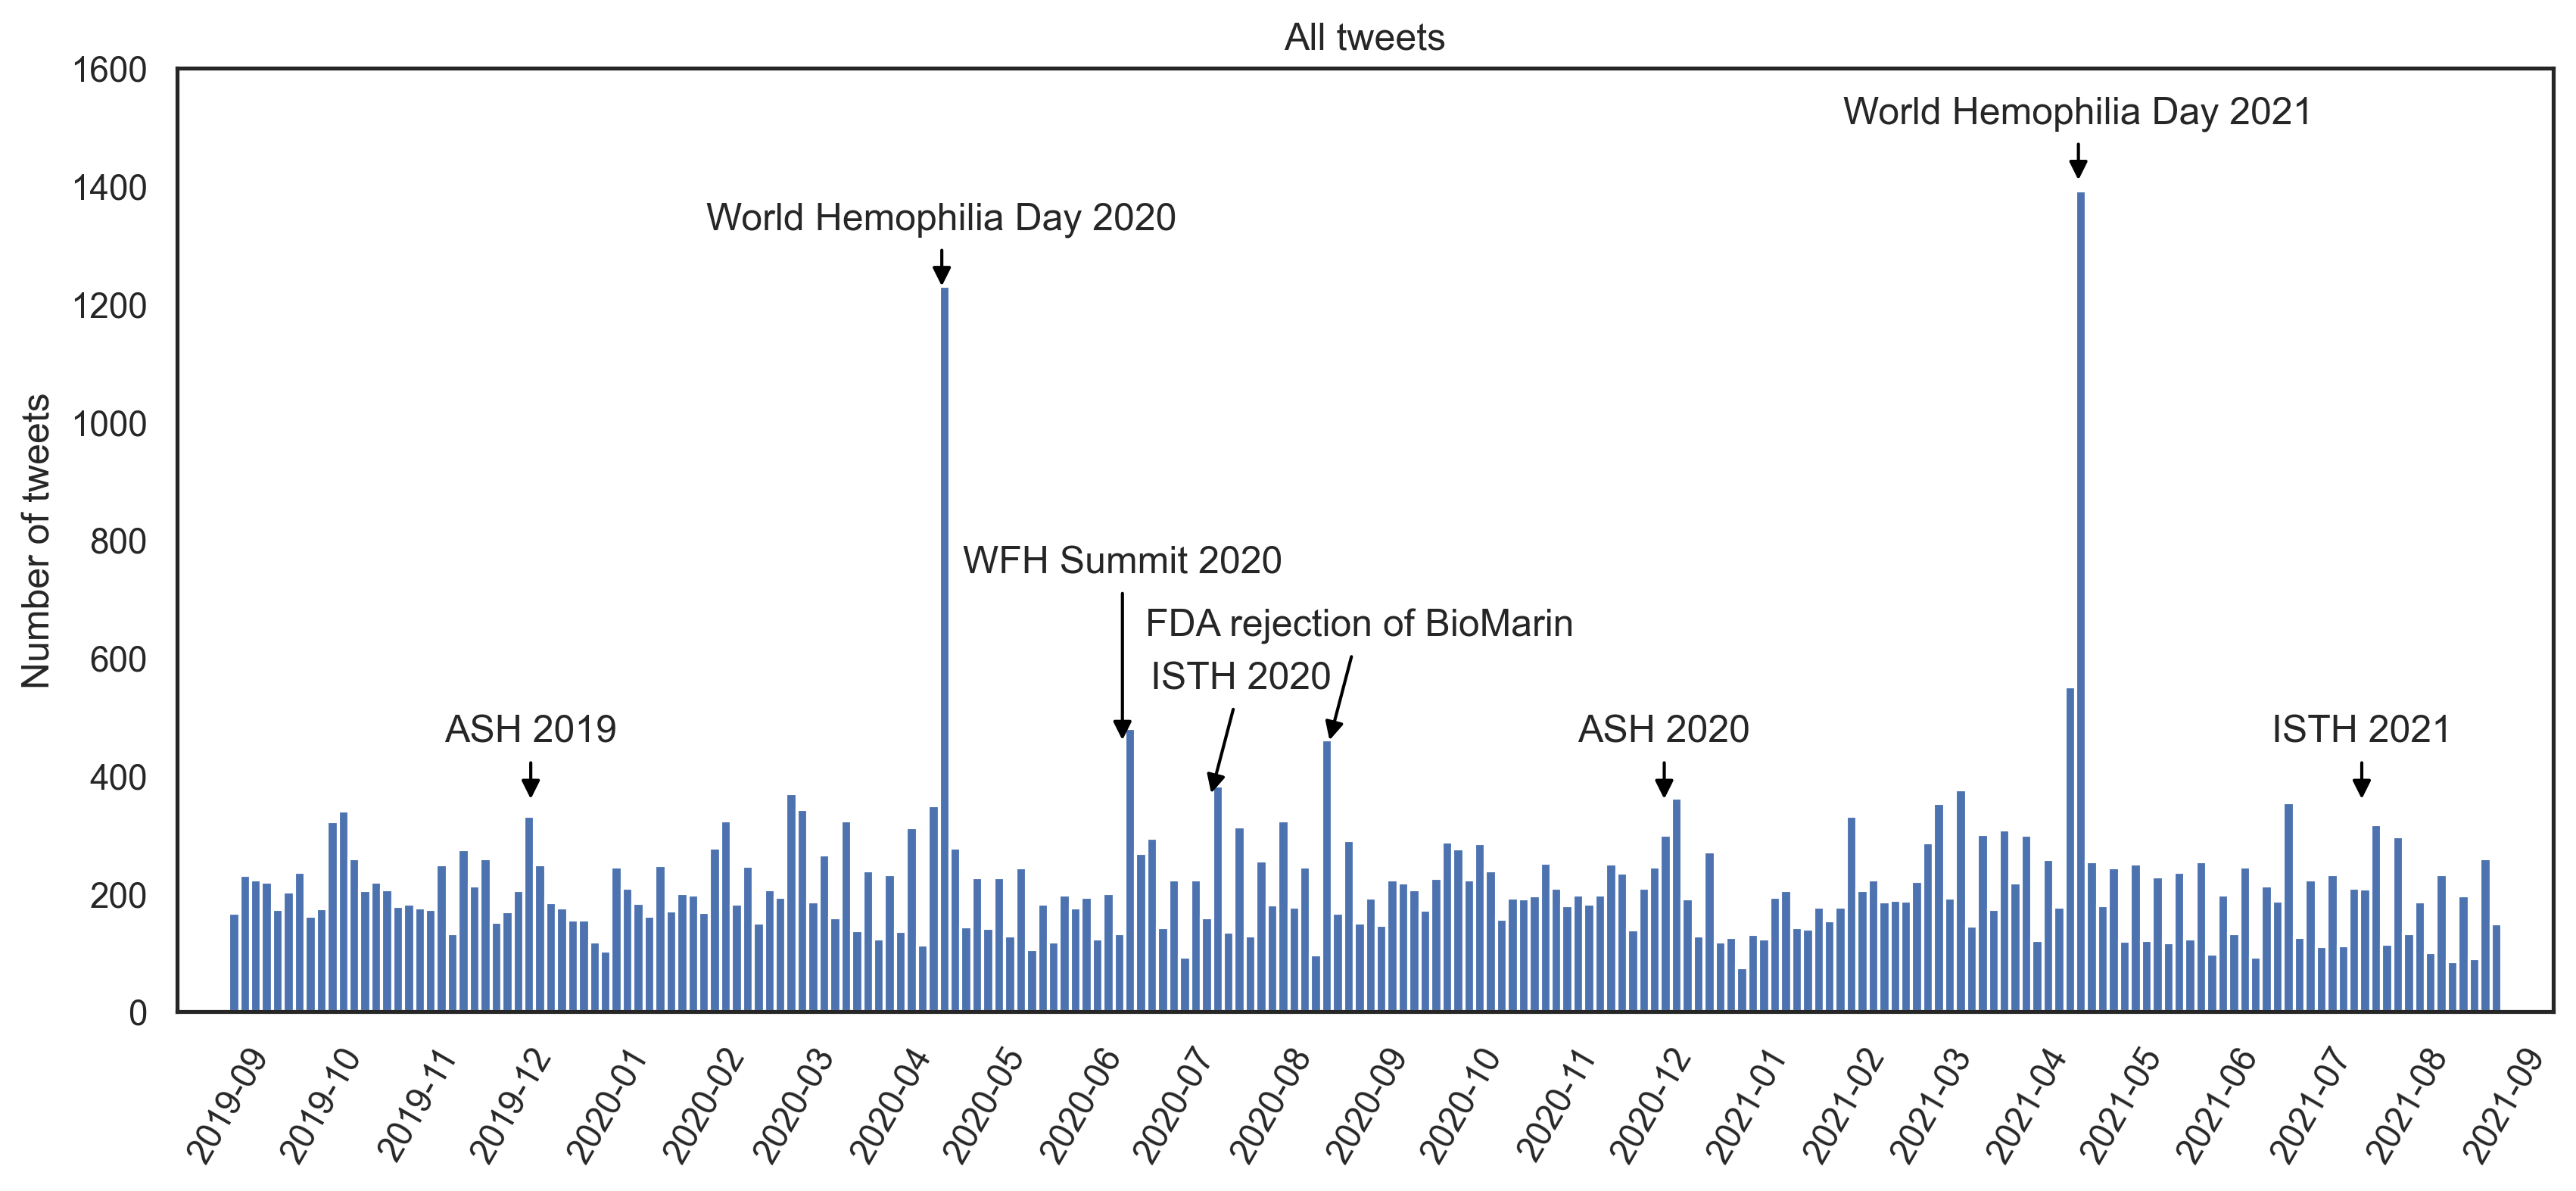

In [25]:
import datetime as dt
sb.set(rc={"figure.dpi":300, 'savefig.dpi':300})

sb.set_theme(style='white')


c1 = mdates.date2num(df['date'])

fig, ax1 = plt.subplots(1,1)

ax1.hist(c1, bins=208) #Spikes at World Hemophilia Day


fmt_half_year = mdates.MonthLocator(interval=1)
ax1.xaxis.set_major_locator(fmt_half_year)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))


ax1.title.set_text('All tweets')

#ax4.title.set_text('Contamination')
#ax5.title.set_text('Inhibitors')
#ax6.title.set_text('Vaccine')

ax1.set_ylabel('Number of tweets')

ax1.annotate('World Hemophilia Day 2020', (mdates.date2num(dt.datetime(2020, 4, 17)), 1220), xytext=(0, 20), 
            textcoords='offset points', ha='center', arrowprops=dict(color='black', arrowstyle='-|>'))
ax1.annotate('World Hemophilia Day 2021', (mdates.date2num(dt.datetime(2021, 4, 17)), 1400), xytext=(0, 20), 
            textcoords='offset points', ha='center', arrowprops=dict(color='black', arrowstyle='-|>'))
ax1.annotate('FDA rejection of BioMarin', (mdates.date2num(dt.datetime(2020, 8, 19)), 450), xytext=(10, 35), 
            textcoords='offset points', ha='center', arrowprops=dict(color='black', arrowstyle='-|>', ))
ax1.annotate('ASH 2019', (mdates.date2num(dt.datetime(2019, 12, 7)), 350), xytext=(0, 20), 
            textcoords='offset points', ha='center', arrowprops=dict(color='black', arrowstyle='-|>'))
ax1.annotate('ASH 2020', (mdates.date2num(dt.datetime(2020, 12, 5)), 350), xytext=(0, 20), 
            textcoords='offset points', ha='center', arrowprops=dict(color='black', arrowstyle='-|>'))
ax1.annotate('ISTH 2020', (mdates.date2num(dt.datetime(2020, 7, 12)), 360), xytext=(10, 35), 
            textcoords='offset points', ha='center', arrowprops=dict(color='black', arrowstyle='-|>'))
ax1.annotate('ISTH 2021', (mdates.date2num(dt.datetime(2021, 7, 17)), 350), xytext=(0, 20), 
            textcoords='offset points', ha='center', arrowprops=dict(color='black', arrowstyle='-|>'))
ax1.annotate('WFH Summit 2020', (mdates.date2num(dt.datetime(2020, 6, 14)), 450), xytext=(0, 55), 
            textcoords='offset points', ha='center', arrowprops=dict(color='black', arrowstyle='-|>'))

temp = plt.xticks(rotation=60)

ax1.set_ylim([0,1600])

print(plt.xlim())
plt.xlim(18123.5, 18886.5)
fig = plt.gcf()
fig.set_size_inches(13.5, 5.5)